## HB_FakeData
A test file for testing hierarchical bayes. Also a practice run for use jupyter notebooks
  * Uses
  * The
  * Same
  * Formatting
  * As
  * Github
  * Readmes

HM 2/3

In [2]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt

Function for generating a single aliased lag-lag likelihood

In [14]:
def fake_LL(lagtrue, alias_width = 30, true_width = 30, rel_height = 1):
    xtrue, ytrue = lagtrue

    def outfunc(x,y):
        out = 0
        for i in [0,1]:
            for j in [0,1]:
                dx = x - (180 + 360*i)
                dy = y - (180 + 360*j)
                r2 = dx**2 + dy**2
                out += jnp.exp(-r2/alias_width**2/2)

        r2 = (x - xtrue)**2 + (y - ytrue)**2
        out+= jnp.exp(-r2/true_width**2/2) * rel_height
        return(out)
    return(outfunc)

Test this function

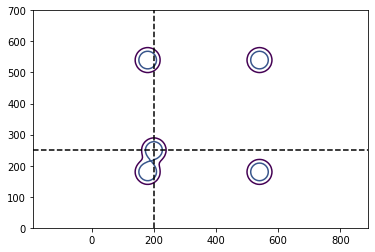

In [15]:
scanrange = jnp.linspace(0,700, 128)
lagtrue = [200, 250]
X,Y = jnp.meshgrid(scanrange, scanrange)
f = fake_LL(lagtrue = lagtrue, alias_width = 20, rel_height= np.random.rand()*0.5+0.5, true_width= 20)
Z = f(X,Y)
plt.contour(X,Y,Z, levels = np.max(Z)*np.exp([-2,-1,0]))
plt.axvline(lagtrue[0], c='k',ls='--')
plt.axhline(lagtrue[1], c='k',ls='--')
plt.axis('equal')
plt.show()

/tmp/ipykernel_90/1080445851.py:16: UserWarning: There are not enough devices to run parallel chains: expected 50 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(50)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = numpyro.infer.MCMC(
sample: 100%|██████████| 200/200 [00:00<00:00, 1552.11it/s, 7 steps of size 7.50e-01. acc. prob=0.96]


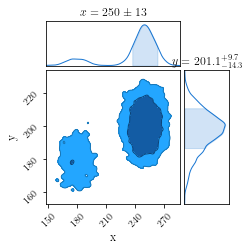

In [56]:
init_lags = [250,200]
true_lags = [250,200]

potential_func = fake_LL(lagtrue = true_lags, alias_width = 10, rel_height= np.random.rand()*0.5+0.5, true_width= 10)

def model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(0,1000))
    y = numpyro.sample('y', numpyro.distributions.Uniform(0,1000))

    numpyro.factor('log_pot', jnp.log(  potential_func(x,y))  )


#sampler_kernel = numpyro.infer.NUTS(model = model, init_strategy=numpyro.infer.init_to_value(values = {'x': init_lags[0], 'y': init_lags[1]}))
sampler_kernel = numpyro.infer.NUTS(model = model, init_strategy=numpyro.infer.init_to_uniform())

sampler = numpyro.infer.MCMC(
    sampler_kernel,
    num_warmup=100,
    num_samples=100,
    num_chains=50,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(12))
output = sampler.get_samples()
c = ChainConsumer()
c.add_chain([output['x'],output['y']], parameters=['x','y'])
c.plotter.plot()
plt.show()

Test Numpyro's ability to recover these contours for a single source

## Fake Data

In this section we generate and plot fake data for use in the numpyro model

In [59]:
#R-L Slopes, Offsets & Spreads
alpha_RL = [0.5, 0.5]
beta_RL = [0.5,0.5]
delta_RL = [0.5*2,0.5*2]

#Similarity band left and right
alpha_sim = 1
delta_sim = 0.25

def makelags(L, lagsim = True, lagsim_prop=False):

    N=len(L)
    #Make initial raft of lags
    lags_1 = np.exp(alpha_RL[0]*np.log(L) + beta_RL[0]+ np.random.normal(size=N)*delta_RL[0])
    lags_2 = np.exp(alpha_RL[1]*np.log(L) + beta_RL[1]+ np.random.normal(size=N)*delta_RL[1])

    if lagsim:
        norm = 1
        good_to_go = np.exp(-(((lags_1 / lags_2) - alpha_sim) / delta_sim)**2 / 2) / np.sqrt(2*np.pi*delta_sim) > np.random.rand(N)

        while False in good_to_go:
            #Indices of cells that need to be updated
            inds = np.where(good_to_go==False)[0]

            #Re-roll required cells
            lags_1[inds] = np.exp(alpha_RL[0]*np.log(L[inds]) + beta_RL[0])+ np.random.normal(size=len(inds))*delta_RL[0]
            lags_2[inds] = np.exp(alpha_RL[1]*np.log(L[inds]) + beta_RL[1])+ np.random.normal(size=len(inds))*delta_RL[1]

            #Use proportionality or linear relationship
            if lagsim_prop==True:
                dex = (( (lags_1[inds] / lags_2[inds]) - alpha_sim) / delta_sim)**2
            else:
                dex = (( (lags_1[inds]*alpha_sim - lags_2[inds])) / delta_sim)**2

            #Check if updated cells are good or need another pass
            good_to_go[inds] = np.exp(-dex/2) / norm > np.random.rand(len(inds))

    return(lags_1,lags_2)

In [60]:
#Actually generate the lags
Nsources = 1000
Lmin = 1
Lmax = 1000
L = np.exp(np.random.uniform(low = np.log(Lmin), high = np.log(Lmax), size=Nsources)) # Log Uniform Dist
L = np.random.uniform(low = Lmin, high = Lmax, size=Nsources) # Uniform

lags = makelags(L, True, False)
print("Lags generated")

Lags generated


Plotting


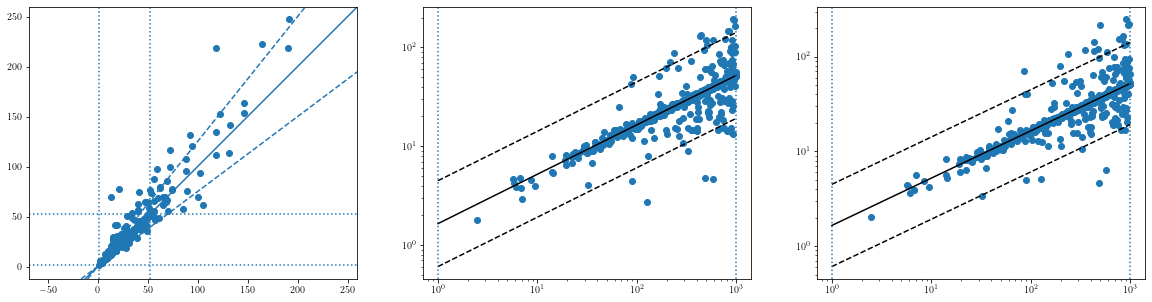

Done


In [61]:
print("Plotting")
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].scatter(lags[0],lags[1])
ax[0].axline([0,0], slope = alpha_sim)
ax[0].axline([0,0], slope = alpha_sim+delta_sim , ls='--')
ax[0].axline([0,0], slope = alpha_sim-delta_sim, ls='--')
ax[0].axis('equal')

ax[0].axvline( np.exp(np.log(Lmin)*alpha_RL[0] + beta_RL[0]), ls=':')
ax[0].axhline( np.exp(np.log(Lmin)*alpha_RL[1] + beta_RL[1]), ls=':')
ax[0].axvline( np.exp(np.log(Lmax)*alpha_RL[0] + beta_RL[0]), ls=':')
ax[0].axhline( np.exp(np.log(Lmax)*alpha_RL[1] + beta_RL[1]), ls=':')

plotspace = np.linspace(Lmin,Lmax, 2)
for i in [1,2]:
    ax[i].scatter(L,lags[i-1])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1]), c='k', ls='-')
    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1] - delta_RL[i-1]), c='k', ls='--')
    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1] + delta_RL[i-1]), c='k', ls='--')

    ax[i].axvline(Lmin, ls=':')
    ax[i].axvline(Lmax, ls=':')

plt.show()
print("Done")
